In [15]:
# By Ken, date: 2021.12.8
import numpy as np # version: 1.20.1
import pandas as pd # version: 1.2.4
import matplotlib.pyplot as plt # version: 3.3.4
from sklearn.preprocessing import StandardScaler  # sklearn version: 0.24.1

class FNN():
    '''
    this is a implementation of a fully connected neural network (FNN) 
    using Stochastic Gradient Descent (SGD) and backprop algorithm.
    hidden layer activation currently support only ReLu.
    output layer activation currently support only sigmoid.
    
    Interface:
        add_layer(), add_output_layer() method can be used to construction the architecture of the neural network.
        Input() method can be used to input training data.
        train() method is used to start the training process.
        predict() method is used to calculate prediction.
        export_model() method can be used to export parameters of a trained network for later model reconstruction.
        load_model() method can be used to reconstruct of model.
        
    user can also play around with other internal use method, such as:
        forward_prop() : forward pass algorithm
        backward_prop() : backward propogation algorithm
    '''
    def __init__(self, epochs=10, learning_rate=0.01):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.w = {} # weights of the network, dictionary key is be the name of the layer
        self.layer_name_list = [] # store layer names for each layer in order
        self.output_layer_flag = 0 # indicate if the network contains output layer or not
        self.xtrain = np.array([]) # store training data
        self.ytrain = np.array([]) # store training data
        self.history_training_cost = None # store cost for each epochs during trianing
        
    def Input(self, xtrain, ytrain):
        '''
        Description
        ----------
        feed in training data (n_samples, n_features) and label.
        
        Parameters
        ----------
        xtrain : ndarray, DataFrame
            training data X, will be converted to ndarray, and added bias column.

        ytrain : ndarray, arraylike
            label data y, will be converted to ndarray.
        '''
        # convert to numpy array if it is a pandas dataframe
        if not isinstance(xtrain, np.ndarray): 
            xtrain = xtrain.values
            ytrain = ytrain.values
        self.xtrain = self.augmentation(xtrain) # add bias column
        self.ytrain = ytrain
        return self
        
    def add_layer(self, n_inputs, n_units, layer_name, random_state=None):
        '''
        Description
        ----------
        adding a hidden layer on top of the existing nueral network architecture, output layer should yet be defined.
        'He initialization' is used for weight initialization.

        Parameters
        ----------
        n_inputs : int
            number of inputs of this layer.

        n_units : int
            number of neurons (outputs) of this layer.
            
        layer_name : str
            unique name to identify this layer.
            
        random_state : int, default None
            random seed to control weight initialization.
        '''
        # if output layer is defined, cannot add layer further
        if self.output_layer_flag == 1:
            print("add layer fail: output layer already defined, cannot add another layer!")
            return self
        
        # check if number of input is consistent with that of previous layer
        if len(self.layer_name_list):      
            previous_layer_name = self.layer_name_list[-1]
            previous_layer = self.w[previous_layer_name]
            if n_inputs != previous_layer.shape[0]:
                print('*** add layer fail: n_inputs is inconsistent with the previous layer output shape!')
                return self
        
        # layer_name need to be unique for each layer in the structure
        if len(self.layer_name_list) and (layer_name in self.layer_name_list):
            print('add layer fail: layer name already used')
            return self
        
        # He initialization technique is used to generate random weights for this layer
        self.w[layer_name] = self.He_initialization(n_units, n_inputs, random_state=random_state) # store this weights
        self.layer_name_list.append(layer_name) # update the layer name list for the network
        return self
    
    def add_output_layer(self, n_outputs, layer_name, random_state=None):
        '''
        Description
        ----------
        adding a output layer on top of the existing network architecture, should have at least one hidden layer in the nueral network.
        number of inputs of this layer is inferred from previous layer.
        'He initialization' is used for weight initialization.

        Parameters
        ----------
        n_outputs : int
            number of neurons (outputs) of this layer.
            
        layer_name : str
            unique name to identify this layer.
            
        random_state : int, default None
            random seed to control weight initialization.
        '''
        # check if output layer already exists
        if self.output_layer_flag == 1:
            print("add output layer fail: output layer already defined!")
            return self
        
        # check at least having 1 hidden layer
        if len(self.layer_name_list)==0:           
            print("add output layer fail: 0 depth network structure!")
            return self
        
        # check layer name is unique
        if len(self.layer_name_list) and (layer_name in self.layer_name_list):
            print('add output layer fail: layer name already used')
            return self
        
        # infer number of inputs of this layer from the previous layer
        previous_layer_name = self.layer_name_list[-1]
        n_inputs = self.w[previous_layer_name].shape[0]
        
        # He initialization technique is used to generate random weights for this layer
        self.w[layer_name] = self.He_initialization(n_outputs, n_inputs, random_state=random_state) # store this weights
        self.layer_name_list.append(layer_name) # update the layer name list for the network
        self.output_layer_flag = 1 # flag: output layer is defined
        return self
        
    def train(self,):
        '''
        Description
        ----------
        use Stochastic Gradient Descent (SGD) to train the nueral network
        '''
        # check network at least has two layer, 1 hidden layer, 1 output layer
        if len(self.w)<2:
            print('train fail: network depth need to be larger than 1, and including 1 output layer')
            return
        
        # check if output layer is already defined
        if self.output_layer_flag==0:
            print('train fail: missing output layer!')
            return
        
        # stochastic gradient descend
        self.SGD(self.epochs)
        
        return self
        
    def SGD(self, epochs):
        '''
        Description
        ----------
        perform Stochastic Gradient Descent (SGD)
        calculate gradient using one randomly selected sample from X at each iteration
        loss function: cross entropy loss
        use forward propogation to calculate outputs
        use backward propogation to update weights
        
        training cost for each epochs is store in: self.history_training_cost
        
        Parameters
        ----------
        epochs : int
            number of epochs.
        '''
        n_samples = self.xtrain.shape[0] # number of samples in training dataset
        index_arr = np.arange(n_samples) # array of index to perform stochastic selection
        history_training_cost = [] # store cost for each epochs
        for epoch in range(epochs):
            # for each epochs: shuffle index to simulate random selection of samples to calculate sgd
            np.random.shuffle(index_arr)
            for i in index_arr:
                sample = self.xtrain[i,:].reshape((-1,1)) # convert this stochastically selected sample to column vector
                label = self.ytrain[i]
                
                # forward pass to calculate output at each node (neuron unit) for the current iteration
                # notation: z = W*x, h = g(z), where g(x) is the activation function like ReLu or tanh
                z_dict, h_dict = self.forward_prop(sample) # all result store in dictionary format, keys are layer name
                
                # backward propogation to calculate gradient of W 
                gradient_w, _ = self.backward_prop(z_dict, h_dict, sample, label) # all result store in dictionary format, keys are layer name
                
                # update W for each layer based on gradient 
                for layer_name in self.layer_name_list:
                    self.w[layer_name] = self.w[layer_name] - self.learning_rate * gradient_w[layer_name]
            
            # calculate cost of training data after each epoch
            train_yhat = self.predict(self.xtrain, threshold=0.5, add_bias=False, return_proba=True) # use this newly updated weights to predict the label: yhat
            train_loss = self.cross_entropy_loss(self.ytrain, train_yhat) # calculate cross entropy loss for each sample in training set
            train_cost = train_loss.sum() / len(self.ytrain) # cost = average cross entropy
            history_training_cost.append(train_cost) # store result

        # save result
        self.history_training_cost = history_training_cost 
        return self
                
    def forward_prop(self, sample):
        '''
        Description
        ----------
        perform forward propogation to calculate output at each layer
        activation for hidden layers is ReLu
        activation for output layer is sigmoid
        
        Parameters
        ----------
        sample : ndarray
            column vector of sample.
            
        Return
        ----------
        z_dict : dict
            result of z (value before apply activation) for each layer
        h_dict : dict
            result of h (output of the layer) for each layer
        '''
        # using ReLu for activation in hidden layer
        cur_input = sample # input (column vector) of current layer
        z_dict = {}# store output of each layer in this iteration
        h_dict = {} # store z = W*x of each layer in this iteration
        for i in self.layer_name_list:
            cur_w = self.w[i] # weights of current layer
            cur_z = np.dot(cur_w, cur_input) # W*x
            z_dict[i] = cur_z # store result
            
            if i!=self.layer_name_list[-1]: # if not output layer, use activation ReLu
                cur_h = self.ReLu(cur_z) # output of current layer: h = ReLu(W*x)
            else: # output layer use sigmoid activation
                cur_h = self.sigmoid(cur_z)
            
            h_dict[i] = cur_h # store result
                
            cur_input = np.insert(cur_h, 0, 1, axis=0) # input of next layer is output of this layer, insert bias term
        return z_dict, h_dict # z, h are column vectors, like sample
        
    def backward_prop(self, z_dict, h_dict, sample, label):
        '''
        Description
        ----------
        perform backward propogation, calculate gradient 
        activation for hidden layers is ReLu
        activation for output layer is sigmoid
        loss function: cross entropy loss
        
        Parameters
        ----------
        z_dict : dict
            result z from forward propogation.
        h_dict : dict
            result h from forward propogation.
        sample : ndarray
            column vector of sample.
        label : int
            label of the sample.
        
        Return
        ----------
        gradient_w : dict
            gradient of w at this iteration
        gradient_z : dict
            gradient of z at this iteration
        '''
        gradient_w = {i:None for i in self.layer_name_list} # store gradient of w for each layer
        gradient_z = {i:None for i in self.layer_name_list} # store gradient of z for each layer
        n = len(self.layer_name_list)
        for i in range(n-1,-1,-1):# starting from last layer
            cur_layer_name = self.layer_name_list[i]
            if i==n-1: # this is output layer use subscript d to represent
                # 1. dJ/dz_d = -t + sigmoid(z_d), for cross entropy loss gradient, sigmoid activation 
                dJdz = -label + self.sigmoid(z_dict[cur_layer_name]) # dJ/dz_d , column vector
                gradient_z[cur_layer_name] = dJdz # store result
                
                # 2. ▽(w_d)J = dJ/dz_d * (1 (h_d-1)^T)
                previous_layer_name = self.layer_name_list[i-1]
                A = np.insert(h_dict[previous_layer_name], 0, 1, axis=0).T # (1 (h_d-1)^T)
                gradient_w[cur_layer_name] = np.dot(dJdz, A) # ▽(w_d)J, store gradient for output layer
                
                # 3. ▽(z_d-1)J = g'(z_d-1) *. ((W_bar_d)^T * dJ/dz_d), g' is derivative of ReLu, either 0 or 1
                B = z_dict[previous_layer_name] # z_d-1
                C = self.derivative_ReLu(B) # g'(z_d-1)
                D = self.w[cur_layer_name][:,1:].T # (W_bar_d)^T, note: W_bar means does not contain bias term
                gradient_z[previous_layer_name] = C * np.dot(D, dJdz) # ▽(z_d-1)J , store result
            
            elif i==0: # this is the first layer
                # 1. ▽(w_1)J = ▽(z_1)J * (1 x^T)
                A = gradient_z[cur_layer_name] # ▽(z_1)J
                B = sample.T # (1 x^T)
                gradient_w[cur_layer_name] = np.dot(A, B) # ▽(w_1)J , store result
                
            else: # this is a hidden layer
                previous_layer_name = self.layer_name_list[i-1]
                # 1. ▽(w_j)J = ▽(z_j)J * (1 (h_j-1)^T)
                A = gradient_z[cur_layer_name] # ▽(z_j)J
                B = np.insert(h_dict[previous_layer_name], 0, 1, axis=0).T # (1 (h_j-1)^T)
                gradient_w[cur_layer_name] = np.dot(A, B)
                # 2. ▽(z_j-1)J = g'(z_j-1) *. ((W_bar_j)^T * ▽(z_j)J)
                C = z_dict[previous_layer_name] # z_j-1
                D = self.derivative_ReLu(C) # g'(z_j-1)
                E = self.w[cur_layer_name][:,1:].T # (W_bar_j)^T, note: W_bar means does not contain bias term
                gradient_z[previous_layer_name] = D * np.dot(E, A) # ▽(z_d-1)J , store result
        
        return gradient_w, gradient_z
        
    def augmentation(self, x):
        '''
        Description
        ----------
        return a copy of x with added bias column
        
        Parameters
        ----------
        x : ndarray
        '''
        n, m = x.shape
        ones = np.ones((n, 1))
        return np.hstack((ones, x))
            
    def He_initialization(self, n_units, n_inputs, random_state=None):
        '''
        Description
        ----------
        perform weight initialization for a layer
        He Initialization is a popular choice for ReLu
        defined as: zero-mean Gaussian distribution whose standard deviation (std) is sqrt(2/n), 
        where n is the number of input feature of the layer
        initialize b (bias column) = 0
        
        Parameters
        ----------
        n_units : int
            number of neurons (outputs) of the layer.
            
        n_inputs : int
            number of inputs of the layer.
            
        random_state : int, default None
            random seed to control weight initialization.
        '''
        rng = np.random.default_rng(random_state) # random generator
        std = np.sqrt(2/n_inputs) # standard deviation (std) is sqrt(2/n)
        init_w = rng.normal(loc=0, scale=std, size=(n_units, n_inputs)) # 0 mean, std=sqrt(2/n) gaussian distribution
        b = np.zeros((n_units, 1)) # initialize b = 0
        return np.hstack((b, init_w))
        
    def predict(self, x, threshold=0.5, add_bias=True, return_proba=False):
        '''
        Description
        ----------
        perform prediction using x and the current weights of the neural network
        
        Parameters
        ----------
        x : ndarray
            input data of x
        
        threshold : float, default 0.5
            if predicted probabilistic value >= threshold then predicted label is 1, otherwise 0
            changing this number to specify weight of label
        
        add_bias : bool, default True
            default is to add bias to x, if x already contains bias column, set this to False.
            
        return_proba : bool, default False
            default is to return predicted label. If True, return predicted probabilistic values.
            
        Return
        ----------
        return ndarray of pridected probabilistic values or label depending on the parameter 'return_proba'
        '''
        # convert to ndarray
        if not isinstance(x, np.ndarray):
            x = x.values
        
        # add bias column to x
        if add_bias:
            x = self.augmentation(x)
            
        # check consistency of data shape
        first_layer = self.layer_name_list[0]
        if x.shape[1]!=self.w[first_layer].shape[1]:
            print('input shape is inconsistent, number of features should be %d (%d instead)'%(self.w[first_layer].shape[1]-1, x.shape[1]-1))
            return None
            
        # compute the output using w
        yhat_list = []
        for i in range(len(x)):
            sample = x[i,:].reshape((-1,1)) 
            _, h_dict = self.forward_prop(sample)
            yhat = h_dict[self.layer_name_list[-1]][0,0]
            yhat_list.append(yhat)
        if return_proba:
            return np.array(yhat_list) # return probability of label
        else:
            return (np.array(yhat_list)>=threshold) * 1 # convert to label of 0 and 1
    
    def cross_entropy_loss(self, y, yhat):
        '''
        Description
        ----------
        calculate cross entropy loss : -y*log(yhat) - (1-y)*log(1-yhat)
        
        Parameters
        ----------
        y : ndarray
            true label
        
        yhat : ndarray
            predicted probabilistic values
            
        Return
        ----------
        cross entropy loss
        '''
        loss = -y*np.log(yhat) - (1-y)*np.log(1-yhat)
        return loss
    
    def misclassification(self, y, yhat):
        '''
        calculate misclassification rate
        '''
        return (y != yhat).sum() / len(y)
    
    def ReLu(self, x):
        '''
        calculate ReLu function
        '''
        x = x.copy()
        x[x<0] = 0
        return x
    
    def sigmoid(self, x):
        '''
        calculate sigmoid function
        '''
        return 1 / (1+np.exp(-x))
    
    def derivative_ReLu(self, x):
        '''
        calculate derivative of ReLu function
        '''
        x = x.copy()
        return (x>0) * 1
    
    def derivative_sigmoid(self, x):
        '''
        calculate derivative of sigmoid function
        '''
        return self.sigmoid(x) * (1 - self.sigmoid(x))
    
    def export_model(self,):
        '''
        use this function to export parameters of the model for later reconstruction of this model
        '''
        d = {
            'epochs' : self.epochs,
            'learning_rate' : self.learning_rate,
            'w' : self.w,
            'layer_name_list' : self.layer_name_list,
        }
        return d
    
    def load_model(self, d):
        '''
        accept dictionary of parameters to reconstruction of model
        '''
        self.epochs = d['epochs']
        self.learning_rate = d['learning_rate']
        self.w = d['w']
        self.layer_name_list = d['layer_name_list']
        return self

def split(data, train_ratio=0.7, val_ratio=0.15, random_state=None):
    '''
    split data into training, validation, testing set, the results maintain the same distribution 
    '''
    # shuffle data before spliting
    rng = np.random.default_rng(random_state)
    data = rng.permutation(data)

    data_1 = data[data[:,-1]==1] # seperate label 1
    data_2 = data[data[:,-1]==0] # seperate label 0
    # split train, val, test set
    n1 = data_1.shape[0]
    n2 = data_2.shape[0]
    train_split_1 = int(n1*train_ratio)
    train_split_2 = int(n2*train_ratio)
    val_split_1 = int(n1*(train_ratio+val_ratio))
    val_split_2 = int(n2*(train_ratio+val_ratio))
    
    train = np.vstack((data_1[:train_split_1], data_2[:train_split_2]))
    val = np.vstack((data_1[train_split_1:val_split_1], data_2[train_split_2:val_split_2]))
    test = np.vstack((data_1[val_split_1:], data_2[val_split_2:]))
    return train, val, test

def accuracy(y, yhat):
    '''
    calculate accuracy
    '''
    return (y == yhat).sum() / len(y)

def misclassification(y, yhat):
    '''
    calculate misclassification
    '''
    return (y != yhat).sum() / len(y)

In [16]:
# --------------- data preprocessing ---------------
# load data
df = pd.read_csv('../data_banknote_authentication.txt', header=None)
data = df.values
# split data
train, val, test = split(data, train_ratio=0.7, val_ratio=0.15, random_state=1)
x_train, y_train = train[:,:-1], train[:,-1]
x_val, y_val = val[:,:-1], val[:,-1]
x_test, y_test = test[:,:-1], test[:,-1]
# standardize data
std = StandardScaler().fit(x_train)
x_train = std.transform(x_train)
x_val = std.transform(x_val)
x_test = std.transform(x_test)

In [19]:
# --------------- build binary classification network structure ---------------
# netwrok structure:
#  - first hidden layer: n1 units
#  - second hidden layer: n2 units
#  - output layer: 1 units
n1 = 2
n2 = 2
epochs = 20
learning_rate=0.01
print('training model...')
fnn = FNN(epochs=epochs, learning_rate=learning_rate) # initialize network
fnn = fnn.Input(x_train, y_train) # input the training dataset and validation dataset
fnn = fnn.add_layer(4, n1, layer_name='1') # hidden layer1: 2 nueron
fnn = fnn.add_layer(n1, n2, layer_name='2') # hidden layer2: 2 nueron
fnn = fnn.add_output_layer(1, layer_name='output') # output layer with 1 output unit
fnn = fnn.train() # train the network
print('training done!')
# store result
train_cost = fnn.history_training_cost

training model...
training done!


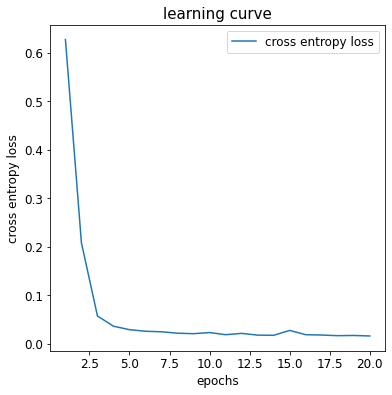

In [20]:
# --------------- plot learning curve: training cost at each epoch ---------------
epochs = range(1,len(train_cost)+1)
plt.figure(figsize=(6,6))
plt.plot(epochs, train_cost, label='cross entropy loss')
plt.title('learning curve', size=15)
plt.xlabel('epochs',size=12)
plt.ylabel('cross entropy loss',size=12)
plt.xticks(size=12)
plt.yticks(size=12)
plt.legend(fontsize=12)

In [21]:
# --------------- prediction ---------------
yhat_train = fnn.predict(x_train)
print('training set prediction accuracy = ', accuracy(y_train, yhat_train))

yhat_test = fnn.predict(x_test)
print('test set prediction accuracy = ', accuracy(y_test, yhat_test))

training set prediction accuracy =  0.9927083333333333
test set prediction accuracy =  0.9951690821256038


In [22]:
# to access the weight of the model
fnn.w

{'1': array([[ 0.46673763, -2.19224602, -1.69881321, -1.75062465, -0.03518804],
        [ 0.63121014, -0.18003656,  1.48068689,  0.68165308,  0.136889  ]]),
 '2': array([[-0.33856153,  2.17269037,  0.28668158],
        [ 1.6857825 , -0.83782329,  2.04833327]]),
 'output': array([[-1.14893215,  1.73241182, -2.64466075]])}

In [25]:
# after getting a satisfying model, we can save the paramters of the model for later use
model_parameters_dict = fnn.export_model()
# load model with this weight
my_model = FNN().load_model(model_parameters_dict)
# the model can now be use to do prediction
yhat_test = my_model.predict(x_test)
print('test set prediction accuracy of reconstructed model = ', accuracy(y_test, yhat_test))

test set prediction accuracy of reconstructed model =  0.9951690821256038
